In [1]:
import numpy as np
from netCDF4 import Dataset
import time
from salishsea_tools import geo_tools

In [2]:
# actually uses only the two southern points as the baseline, two northern points are ignored
lon = [-132.68103, -143.19904, -132.76558, -144.78392] 
lat = [69.181847, 68.805038, 71.980515, 71.536087]

In [67]:
def step_forward(lat1, lon1, d, brng):
    ''' Given a start point, initial bearing, and distance, 
    this process will calculate the destination point
    and final bearing travelling along a great circle arc.
    
    φ2 = asin( sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
    λ2 = λ1 + atan2( sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2 )
    
    φ is latitude
    λ is longitude 
    θ is the bearing (clockwise from north) 
    δ is the angular distance d/R
    d is the distance travelled
    R is the earth’s radius
    
    :arg lat1: Latitude of start point (deg)
    :arg lon1: Longitude of start point (deg)
    :arg d: Distance to destination point (km)
    :arg brng: Initial bearing (rad)
    :returns: Latitude and longitude of destination point (deg)
    '''
    
    R = 6378.1 

    lat1 = np.radians(lat1) 
    lon1 = np.radians(lon1)
    brng = np.radians(brng)

    lat2 = np.arcsin( np.sin(lat1)*np.cos(d/R) +
             np.cos(lat1)*np.sin(d/R)*np.cos(brng))

    lon2 = lon1 + np.arctan2(np.sin(brng)*np.sin(d/R)*np.cos(lat1),
             np.cos(d/R)-np.sin(lat1)*np.sin(lat2))

    lat2 = np.degrees(lat2)
    lon2 = np.degrees(lon2)

    return lat2, lon2

# ------------------------------------------------------------------------------------------------

def great_circle_points(lat1, lon1, lat2, lon2, npts):
    ''' The longitude and latitudes of intermediate points at 
    any fraction along the great circle path between two points 
    is calculated. The haversine in geo_tools calculates the 
    great circle distance between two points.
    
    A = sin((1−f)⋅δ) / sin δ
    B = sin(f⋅δ) / sin δ
    x = A ⋅ cos φ1 ⋅ cos λ1 + B ⋅ cos φ2 ⋅ cos λ2
    y = A ⋅ cos φ1 ⋅ sin λ1 + B ⋅ cos φ2 ⋅ sin λ2
    z = A ⋅ sin φ1 + B ⋅ sin φ2
    φi = atan2(z, √x² + y²)
    λi = atan2(y, x) 
    
    φ is latitude
    λ is longitude 
    f is fraction along great circle route
    (f=0 is point 1, f=1 is point 2)
    δ is the angular distance d/R between the two points.
    
    :arg lat1: Latitude of start point (deg)
    :arg lon1: Longitude of start point (deg)
    :arg lat2: Latitude of start point (deg)
    :arg lon2: Longitude of start point (deg)
    :arg npts: Number of intermediate points along the great circle
    :returns: Latitudes and longitudes of all intermediate points (deg)
    '''
    
    R = 6378.1 
    
    d = geo_tools.haversine(lon1, lat1, lon2, lat2) / R
    lats = np.zeros(npts)
    lons = np.zeros(npts)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    for i in range(npts):
        f = float(i) / float(npts-1.)
        A = np.sin((1 - f) * d) / np.sin(d)
        B = np.sin(f * d) / np.sin(d)
        x = A * np.cos(lat1) * np.cos(lon1) +  B * np.cos(lat2) * np.cos(lon2)
        y = A * np.cos(lat1) * np.sin(lon1) +  B * np.cos(lat2) * np.sin(lon2)
        z = A * np.sin(lat1) +  B*np.sin(lat2)
        lats[i] = np.arctan2(z, np.sqrt(x*x + y*y))
        lons[i] = np.arctan2(y, x)

    lats = np.degrees(lats)
    lons = np.degrees(lons)

    return lats, lons

# ------------------------------------------------------------------------------------------------

def calculate_initial_compass_bearing(pointA, pointB):
    ''' The bearing between two points is calculated.
       
    θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
    φ1,λ1 is the start point
    φ2,λ2 the end point 
    
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    '''
    
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = np.radians(pointA[0])
    lat2 = np.radians(pointB[0])
    
    diffLong = np.radians(pointB[1] - pointA[1])

    x = np.sin(diffLong) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1)
            * np.cos(lat2) * np.cos(diffLong))

    initial_bearing = np.arctan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

# ------------------------------------------------------------------------------------------------

def create_grid_file(filename):
    ''' This function saves the coordinates for all
    points in the defined grid. This grid will then 
    be processed to calculate the scaling factors
    required by NEMO.
    
    :arg filename: Directory and name of netCDF4 file
    '''
    
    dataset = Dataset(filename, 'w')
    x = dataset.createDimension('x', nx)
    y = dataset.createDimension('y', ny)

    lons = dataset.createVariable('grid_lons', 'f8', ('x','y'))
    lats = dataset.createVariable('grid_lats', 'f8', ('x','y'))

    dataset.title = 'Mackenzie Canyon Coordinates Grid'
    dataset.author = 'Idalia A. Machuca'
    dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    dataset.source = 'bitbucket.org/CanyonsUBC/mackenzie_canyon/bathymetry/notebooks/'
    dataset.timeStamp = time.ctime(time.time())
    lons.standard_name = 'Longitude'
    lats.standard_name = 'Latitude'
    lons.units = 'degrees east'
    lons.units = 'degrees north'

    lons[:] = thelons[:]
    lats[:] = thelats[:]

    dataset.close()
    
# ------------------------------------------------------------------------------------------------

def compile_grid_coordinates(nx, ny, lon, lat):
    ''' Uses previously defined functions to calculate
    the longitudes and latitudes of all grid cells in
    the domain defined by its two southern corner
    points.
    
    :arg nx: Grid size (alongshore)
    :arg ny: Grid size (cross-shore)
    :arg lon: List of longitudes of corner points
    :arg lat: List of latitudes of corner points
    :returns: Longitudes and latitudes of all grid points
    '''

    lat2, lon2 = great_circle_points(lat[1], lon[1], lat[0], lon[0], nx)

    thelats = np.zeros((nx, ny))
    thelons = np.zeros_like(thelats)
    thelats[:,0] = lat2
    thelons[:,0] = lon2
    
    dx = geo_tools.haversine(thelons[-1,0], thelats[-1,0], thelons[-2,0], thelats[-2,0])
    print(dx)
    
    angle = 0
    for j in range(1, ny):
        for i in range(0, nx-1):
            prevangle = angle
            bearing = calculate_initial_compass_bearing((thelats[i, j-1], thelons[i, j-1]), 
                                                        (thelats[i+1, j-1], thelons[i+1, j-1]))
            angle = bearing - 90.
            thelats[i,j], thelons[i,j] = step_forward(thelats[i,j-1], thelons[i,j-1], dx, angle)
        i = nx-1
        angle = 2*angle - prevangle
        thelats[i, j], thelons[i, j] = step_forward(thelats[i, j-1], thelons[i, j-1], dx, angle)
    dx2 = geo_tools.haversine(thelons[-1,1], thelats[-1,1], thelons[-2,1], thelats[-2,1])
    print(dx2)
    return thelons, thelats

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [75]:
def plot_grid(nx, ny, lon, lat):
    thelons, thelats = compile_grid_coordinates(nx, ny, lon, lat)

    clon = -140
    clat = 70.5
    colors = cm.rainbow(np.linspace(0, 1, 100*5))
    fig, ax = plt.subplots(figsize=(10,5))
    m = Basemap(width =1e6, height =0.5e6, lon_0=clon, lat_0=clat, projection='stere', resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='0.75', alpha=0.5)
    m.drawparallels(np.arange(-90.,90.,10.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,180.,20.), labels=[0, 0, 0, 1])
    x, y = m(thelons[::4,::4], thelats[::4,::4])
    m.scatter(x, y, color=colors, s=50)
    m.ax = ax
    plt.show()

4.24798602228
4.24798465106


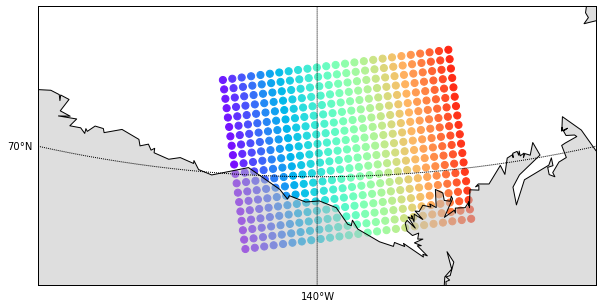

In [76]:
nx = 100; ny = 75
plot_grid(nx, ny, lon, lat)

5.12866613156
5.12866370058


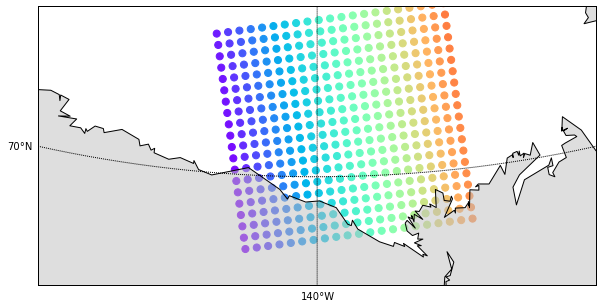

In [77]:
nx = 83; ny = 78
plot_grid(nx, ny, lon, lat)

3.53403874669
3.53403796191


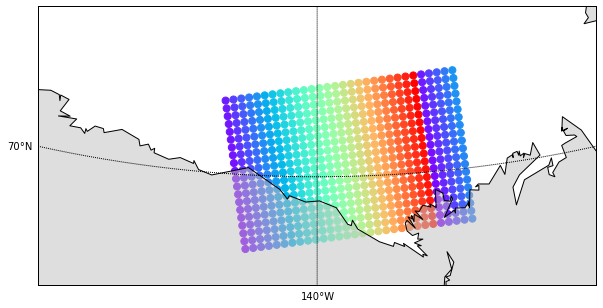

In [78]:
nx = 120; ny = 78
plot_grid(nx, ny, lon, lat)

4.24798602228
4.24798465106


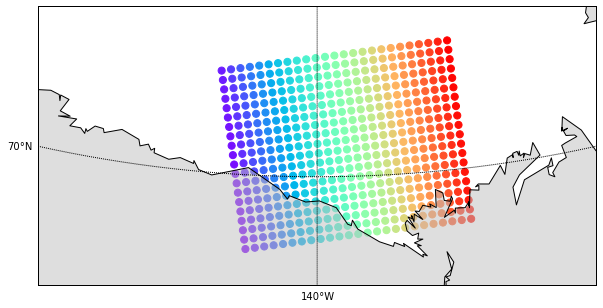

In [79]:
nx = 100; ny = 78
plot_grid(nx, ny, lon, lat)

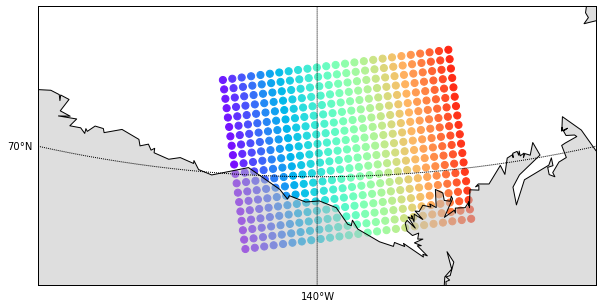

In [24]:
clon = -140
clat = 70.5
colors = cm.rainbow(np.linspace(0, 1, 100*5))
fig, ax = plt.subplots(figsize=(10,5))
m = Basemap(width =1e6, height =0.5e6, lon_0=clon, lat_0=clat, projection='stere', resolution='l')
m.drawcoastlines()
m.fillcontinents(color='0.75', alpha=0.5)
m.drawparallels(np.arange(-90.,90.,10.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,180.,20.), labels=[0, 0, 0, 1])
x, y = m(thelons[::4,::4], thelats[::4,::4])
m.scatter(x, y, color=colors, s=50)
m.ax = ax
plt.show()

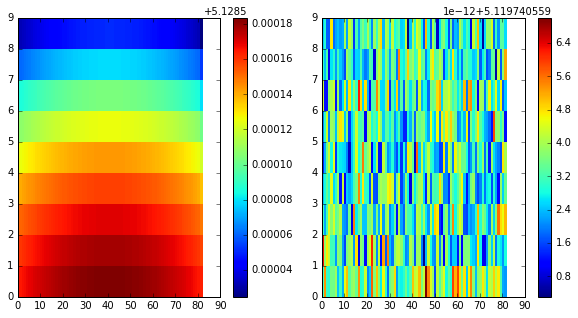

In [66]:
e1t = np.zeros_like(thelats)
e2t = np.zeros_like(thelons)
for i in range(1, nx):
    for j in range(1, ny):
        e1t[i,j] = geo_tools.haversine(thelons[i-1,j], thelats[i-1,j], thelons[i,j], thelats[i,j])
        e2t[i,j] = geo_tools.haversine(thelons[i,j-1], thelats[i,j-1], thelons[i,j], thelats[i,j])
fig, axs = plt.subplots(1,2, figsize=(10,5))
mesh = axs[0].pcolormesh(e1t[1:,1:10].transpose())
fig.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(e2t[1:,1:10].transpose())
fig.colorbar(mesh, ax=axs[1])

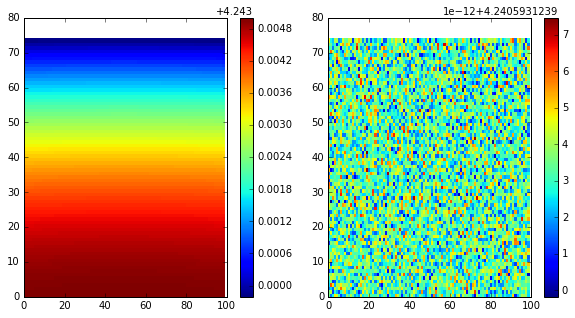

In [62]:
e1t = np.zeros_like(thelats)
e2t = np.zeros_like(thelons)
for i in range(1, nx):
    for j in range(1, ny):
        e1t[i,j] = geo_tools.haversine(thelons[i-1,j], thelats[i-1,j], thelons[i,j], thelats[i,j])
        e2t[i,j] = geo_tools.haversine(thelons[i,j-1], thelats[i,j-1], thelons[i,j], thelats[i,j])
fig, axs = plt.subplots(1,2, figsize=(10,5))
mesh = axs[0].pcolormesh(e1t[1:,1:].transpose())
fig.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(e2t[1:,1:].transpose())
fig.colorbar(mesh, ax=axs[1])

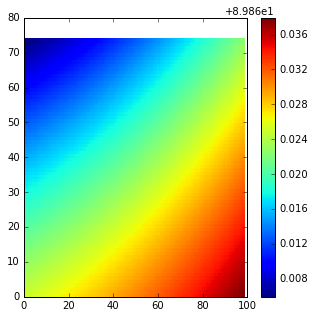

In [10]:
theangle = np.zeros_like(thelats)
for i in range(1, nx):
    for j in range(1, ny):
        angle1 = calculate_initial_compass_bearing((thelats[i-1,j], thelons[i-1,j]), (thelats[i,j], thelons[i,j]))
        angle2 = calculate_initial_compass_bearing((thelats[i,j-1], thelons[i,j-1]), (thelats[i,j], thelons[i,j]))
        theangle[i,j] = angle1 - angle2 + 360.
fig, ax = plt.subplots(1,1, figsize=(5,5))
mesh = ax.pcolormesh(theangle[1:,1:].transpose())
fig.colorbar(mesh, ax=ax)